RFM Summary:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    91.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     0.000000     1.000000       3.750000
25%    13813.250000    17.000000     1.000000     307.415000
50%    15299.500000    50.000000     2.000000     674.485000
75%    16778.750000   141.000000     5.000000    1661.740000
max    18287.000000   373.000000   209.000000  280206.020000


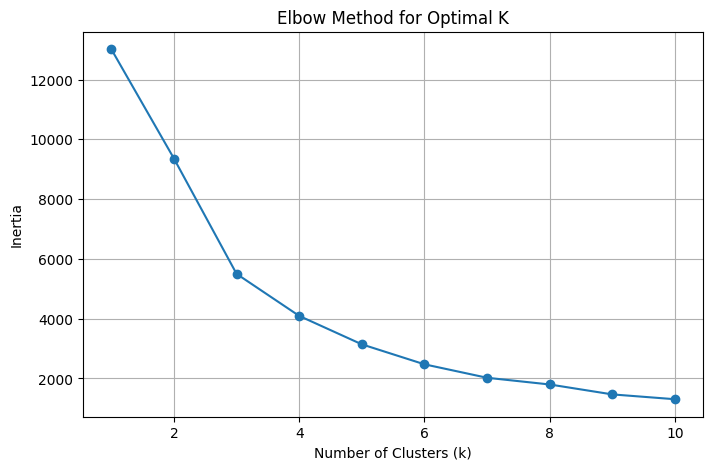

Cluster Profile:
          Recency  Frequency  Monetary
Cluster                              
0           42.7        3.7    1359.0
1          247.1        1.6     480.6
2            6.4       82.5  127338.3
3           14.5       22.3   12709.1


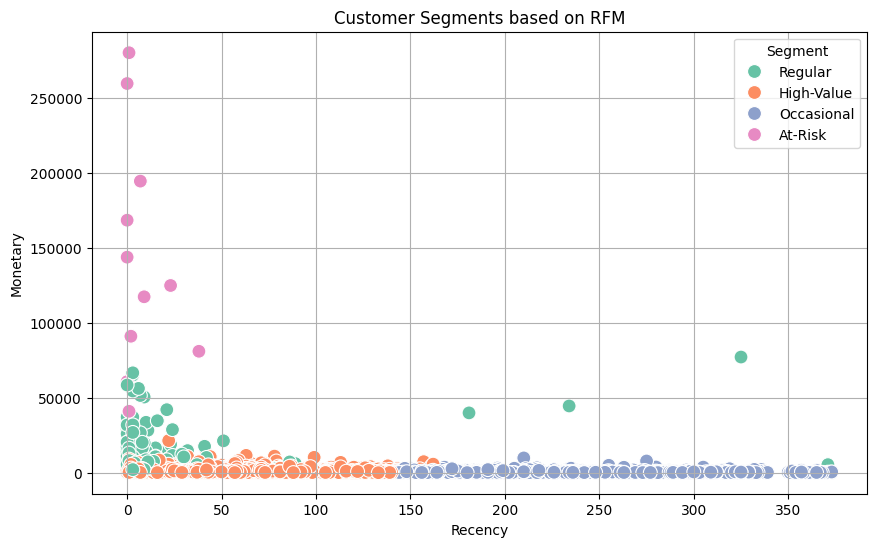

Clustering complete and models saved.


In [2]:
# 📦 Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

# 📂 Step 2: Load Cleaned Dataset
df = pd.read_csv("../data/cleaned_data.csv", parse_dates=["InvoiceDate"])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 🧮 Step 3: Calculate RFM Features
snapshot_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.reset_index(inplace=True)

# 🔍 View RFM Summary
print("RFM Summary:")
print(rfm.describe())

# 🔄 Step 4: Scale the RFM Features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# 📈 Step 5: Elbow Method to Choose Optimal K
inertia = []
K_range = range(1, 11)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

# 🎯 Step 6: Fit KMeans with Optimal K (let's use k=4 as default)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 📊 Step 7: Analyze Cluster Characteristics
cluster_profile = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
print("Cluster Profile:\n", cluster_profile)

# 🏷️ Step 8: Assign Labels to Clusters (customize if needed)
def label_cluster(row):
    if row['Cluster'] == 0:
        return 'High-Value'
    elif row['Cluster'] == 1:
        return 'Occasional'
    elif row['Cluster'] == 2:
        return 'At-Risk'
    else:
        return 'Regular'

rfm['Segment'] = rfm.apply(label_cluster, axis=1)

# 🎨 Step 9: Visualize Clusters (Recency vs Monetary)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='Set2', s=100)
plt.title('Customer Segments based on RFM')
plt.grid(True)
plt.show()

# 💾 Step 10: Save Models for Streamlit App
joblib.dump(kmeans, "../models/kmeans_model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

# ✅ Done
print("Clustering complete and models saved.")
